# Overview

This notebook walks through the process of disaggregating DRB demand data to the nodes of interest. 



In [221]:
# Standard libraries
import numpy as np
import pandas as pd

# Geospatial libraries
import geopandas as gpd

# Data acquisition libraries
from pynhd import NLDI, NHDPlusHR, WaterData

# Step 0: Load data

Load Pywr-DRB nodes.

Load Pywr-DRB USGS data sources, and unpack the list where multiple gauges are listed for a single node. 


In [222]:
### Load data
# Pywr nodes
nodes = pd.read_csv('../model_data/drb_model_nodes.csv', sep = ',')

# Constants
crs = 4386

In [223]:
def parse_usgs_gauges():
    
    ### Load Pywr gauges
    node_gauges = pd.read_csv(f'../model_data/drb_model_usgs_data_sources.csv', sep = ',')
    crs = 4386
    
    # Flatten the list since multiple sites listed for some nodes
    node_gauge_list = []
    node_names = []
    
    for i, gauge in enumerate(node_gauges.USGS_gages.values):
    
        if type(gauge) == str:
            split = gauge.split(', ')
            for s in split:
                if s[0] != '0':
                    s = f'0{s}'
                node_gauge_list.append(s)
                node_names.append(node_gauges.node.iloc[i])
    node_gauges = pd.DataFrame({'station':node_gauge_list,
                               'node':node_names})
    return node_gauges

In [224]:
node_basins = parse_usgs_gauges()


# Step 1: Get basin geometries

Use the station number (with a leading '0') to find each basin.

In [225]:
nldi = NLDI()

n_nodes= len(node_gauges.node)

node_basins.index = node_basins.station
node_basins['geometry'] = ''

for i in range(n_nodes):
    station = node_basins.station.iloc[i]
    basin_data = nldi.get_basins(f'{station}')
    node_basins.at[station, 'geometry'] = basin_data.geometry[0]
    
node_basins = gpd.GeoDataFrame(node_basins, geometry=node_basins['geometry'], crs = crs)

In [226]:
# Export
node_basins.to_csv("./node_basin_geometries.csv")

<AxesSubplot: >

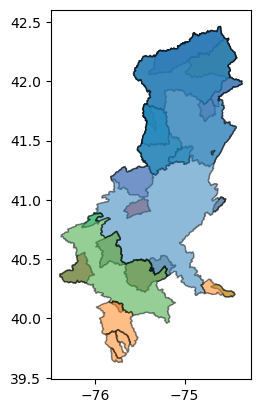

In [229]:
# Visualize
node_basins.plot(column = 'node', edgecolor = 'black', alpha = 0.5)